In [ ]:
""" dayをhourに修正済み
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import time

get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import pickle
import math
import glob
import talib as ta
import shutil
import os

import schedule

#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")
        
# Oandaからcandleデータを取得する。
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    data = []
    for res in JSONRes['candles']:
        temp = [((datetime.datetime.fromisoformat(res['time'][:19]))+datetime.timedelta(hours=+9)).strftime('%Y-%m-%d %H:%M')]#indexとなる時間を追加
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data

def logarism(x):
    return math.log(x)


def get_now_data(time, period_Days, money='USD_JPY', foot = 'D', back_days = 0):
    
    all_data = []
    #time = time.replace(hour=7, minute=0, second=0, microsecond=0)
    #入力された日の当日の7時
    
    global PAST
    past = datetime.timedelta(hours=-PAST)
    
    NY = datetime.timedelta(hours=-14)
    back = datetime.timedelta(days=-back_days)
        
    date_to = time + NY + datetime.timedelta(seconds=-1) + back + past
#     date_from = date_to + datetime.timedelta(days=-period_Days)
    date_from = date_to + datetime.timedelta(hours=-period_Days)
    
    ret = getCandleDataFromOanda(money, api, date_from, date_to, foot)
    month_data = oandaJsonToPythonList(ret)#取得したデータを格納

    all_data.extend(month_data)#データを追加

    # pandas DataFrameへ変換
    df = pd.DataFrame(all_data)

    df.columns = ['Datetime','Volume', 'Open', 'High', 'Low', 'Close']
    df['Open'] = df['Open'].astype('double')
    df['Close'] = df['Close'].astype('double')
    
    
    close = np.array(df["Close"]).astype(float)
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる
    #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
    df["SMA5"]= ta.SMA(close, timeperiod=5) / close * 100
    df["SMA10"]= ta.SMA(close, timeperiod=10) / close * 100
    #df["RSI"] = ta.RSI(close, timeperiod=9) / close * 1000
    #ボリンジャーバンド 
    upper, middle, lower = ta.BBANDS(close, timeperiod=10, nbdevup=2, nbdevdn=2)
    df["BBANDS+σ"] = upper / close * 100
    df["BBANDS-σ"] = lower / close * 100
    
#     df['Rate']=(df['Close']-df['Open'])/df['Open']
    
#     df['Open'] = df['Open'].apply(lambda x: logarism(x))
#     df['Close'] = df['Close'].apply(lambda x: logarism(x))
    
    df['Rate']=(df['Close'].astype('double')-df['Open'].astype('double'))/df['Open'].astype('double')
    df['Rate']=df['Rate']*100
    
    df['Rate']=df['Rate']*1000
    
    df = df.dropna()
    
    df = df.set_index('Datetime')
    #print(df)
    
    
    return df
    
def get_csv(back_days, hours, money):
    
    time = datetime.datetime.now() 
    
    df = get_now_data(time, period_Days=hours, money=money, foot = FOOT , back_days=back_days)
    date_to = (time+datetime.timedelta(days=-back_days)+datetime.timedelta(seconds=-1)).strftime("%Y-%m-%d")
    date_from = (time + datetime.timedelta(hours=-hours)+datetime.timedelta(days=-back_days)).strftime("%Y-%m-%d")
    df.to_csv("csv/"+str(money)+"_"+ date_from + "_" + date_to +"_"+str(hours)+'.csv', mode = 'w')
    print('"'+str(money)+"_"+ date_from + "_" + date_to +"_"+str(hours)+'.csv', end='", ')
    
    return df

def get_moneys_csv(back_days, hours, moneylist):
    csvlist = []
    
    time = datetime.datetime.now()
    date_to = (time+datetime.timedelta(days=-back_days)+datetime.timedelta(seconds=-1)).strftime("%Y-%m-%d")
    date_from = (time + datetime.timedelta(hours=-hours)+datetime.timedelta(days=-back_days)).strftime("%Y-%m-%d")
    
    for i in range (len(moneylist)):
        get_csv(back_days, hours, money=moneylist[i])
        csvlist.extend([str(moneylist[i])+"_"+ date_from + "_" + date_to +"_"+str(hours)+'.csv'])
    
    return csvlist
        
def classify_two(x, c):
        if x<=0:
            c[0]+=1
            return -1
        elif 0<x:
            c[1]+=1
            return 1
        

def predict(dataname, moneyname, test_days, back_day, datanum):

    df = pd.read_csv("csv/"+dataname, index_col='Datetime')
    
    count = [0,0]
    #df['class'] = (df["Rate"]).apply(lambda x: classify(x, count, 0.001))
    df['class'] = (df["Rate"]).apply(lambda x: classify_two(x, count))
    df['class'] = df['class'].shift(-1)
    print("Train Data")
    print(" LOW/HIGH")
    print(count)
    
    X = df.drop('class', axis=1)
    y = df['class']
    X = X.drop(X.index[len(X)-1])
    y = y.dropna()
    
#     df_now = get_now_data(datetime.datetime.now(), period_Days=test_days, money=moneyname, foot = 'D', back_days = back_day)
    df_now = get_now_data(datetime.datetime.now(), period_Days=test_days, money=moneyname, foot = FOOT, back_days = back_day)
    print("money: "+moneyname)
    
    count = [0,0]
    #df['class'] = (df["Rate"]).apply(lambda x: classify(x, count, 0.001))
    df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
    df_now['class'] = df_now['class'].shift(-1)
    print("NOW Data from" +str(test_days)+ "days ago")
    print(" LOW/MID/HIGH")
    print(count)
    
    print("learning data")
    print(df.head(1).index.values, end=' to ')
    print(df.tail(1).index.values)
    
    print("")
    print("test data")
    print(df_now.head(1).index.values,end=' to ')
    print(df_now.tail(1).index.values)
    print("")
    X_now = df_now.drop('class', axis=1)
    
    X_next = X_now.tail(1) #最終予測に利用
    y_now = df_now['class']
    X_now = X_now.drop(X_now.index[len(X_now)-1])
    y_now = y_now.dropna()
    
    X_train = X
    y_train = y
    X_test = X_now
    y_test = y_now
    
    
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
             "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
             "Quadratic Discriminant Analysis"]
    classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
    
    accuracy_scores = []
    precision_scores = []
    next_class = []
    profit = []
    
    clearlist = []
    
    for name, clf in zip(names, classifiers):
        print(name)
        clf.fit(X_train, y_train)
        result = clf.predict(X_test)
        profit, values = calc_profit(result, y_test)
        precision = precision_score(y_test, result, average=None)
        accuracy = accuracy_score(y_test, result)
        confusion = confusion_matrix(y_test, result)
        
        if(precision[0]>0.45 and precision[1]>0.45 and precision[0]!=1 and precision[1]!=1 and accuracy>0.55 and abs(confusion[0][0]-confusion[1][1])<(confusion[0][0]+confusion[1][1])/4):
        #if(precision[0]>0.4 and precision[1]>0.4):
#             score = clf.score(X_test, y_test)
            next_class.extend(clf.predict(X_next))

            print('accuracy_score: ', end='')
            print(accuracy_score(y_test, result))
            accuracy_scores.extend([accuracy_score(y_test, result)])
            print('confusion_matrix: ')
            print(confusion_matrix(y_test, result))
            print('precision_score: ', end='')
            print(precision_score(y_test, result, average=None))
            precision_scores.extend([precision_score(y_test, result, average=None)])

            print(str(len(result))+"days trade")
            print("profit: "+str(profit))

            print('')

            model_name = moneyname + "_" + name + "_" + str(datanum) +".sav"
            #clearlist.extend([model_name])
            print("CLEAR: " + model_name)
            pickle.dump(clf, open("models/"+model_name, 'wb'))

    #print(clearlist)
    return accuracy_scores, precision_scores, next_class, profit

def make_models(test_days, namelist, moneylist, back_days, datanum):
    for i in range(len(namelist)):
        print(namelist[i])
        acc, pre, next_class, profit = predict(namelist[i], moneylist[i], test_days, back_days, datanum)
        print(acc)


def calc_profit(predict_result, true_data):
    win=0
    lose=0
    for i in range(len(predict_result)):
            if (predict_result[i]==-1):#Low予想のとき
                if (predict_result[i]==true_data[i]): #予測成功
                    win+=1
                else:
                    lose+=1
            elif(predict_result[i]==1):#High予想の時
                if (predict_result[i]==true_data[i]): #予測成功
                    win+=1
                else:
                    lose+=1
    profit = win*0.9-lose #利率を算出
    values = predict_result*profit #予測結果×利率により予測の価値を算出
    return profit, values

def plot_result(index, predict_result, true_data):
    plt.figure(figsize=(20,5))
    index = index.astype(float)

    color = []
    marker = []
    accuracy = []
    
    for x in range(0,len(predict_result)):
        if true_data.values[x] == predict_result[x]:
            color.extend(['blue'])
            accuracy.extend([1])

        else:
            color.extend(['red'])
            accuracy.extend([0])


    plt.scatter(index.index.values, index["Rate"].values, color=color)

    plt.xticks(rotation=90)
    plt.show()
    
    return accuracy


def ensemble(model_names, moneyname, days):
    
#     df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneyname, foot = 'D', back_days = NIGHT)###########
    global PAGE
    
    temp = PAGE
    PAGE = trader.select_money(moneyname, temp)
    
    df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneyname, foot = FOOT, back_days = NIGHT)###########
    print("money: "+moneyname)
    count = [0,0]
    
    df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
    df_now['class'] = df_now['class'].shift(-1)
    print("NOW Data from" +str(days)+ "days ago")
    print(" LOW/MID/HIGH")
    print(count)

    print("")
    print("test data")
    print(df_now.head(1).index.values,end=' to ')
    print(df_now.tail(1).index.values)
    print("")
    X_now = df_now.drop('class', axis=1)
    
    X_next = X_now.tail(1) #最終予測に利用
    y_now = df_now['class']
    X_now = X_now.drop(X_now.index[len(X_now)-1])
    y_now = y_now.dropna()
    
    values = []
    values_sum = []
    win=0
    lose=0
    answer = 0
    
    for x in range(len(model_names)):
        clf = pickle.load(open(model_names[x], 'rb')) #clfをload
        print(model_names[x])
        result = clf.predict(X_now) #predict
        precision = precision_score(y_now, result, average=None)
        #if(precision[0]!=0 and precision[1]!=0 and precision[0]!=1 and precision[1]!=1):
        if(1):
       
            #score表示
            print("accuracy_score: ", end="")
            print(accuracy_score(y_now, result))
            print("precision_score: ", end="")
            print(precision)
            print(confusion_matrix(y_now, result))

            profit, values = calc_profit(result, y_now) #予測結果について利率と、予測*利率による予測の信頼性を算出

            #answer += clf.predict(X_next)[0]*profit
            answer += clf.predict(X_next)[0]*accuracy_score(y_now, result)
            #values = result*accuracy_score(y_now, result)
            if len(values_sum)==0:#1回目は配列をコピー
                values_sum = values
            else:
                values_sum += values #２回目からは加算
            print(values)
    
        #plot_result(X_now, result, y_now)
        
    print(values_sum)
    
    if(values_sum==[]):
        print("No model")
        return 0
    
    ensemble_result = np.where(values_sum<0, -1, 1) #クラス分類
    
    print("")
    print("ensemble_result: ",end='')
    print(accuracy_score(y_now.values, ensemble_result))
    print(ensemble_result)
    print(y_now.values)
    print(values_sum)
    print("precision_score: ", end="")
    print(precision_score(y_now, ensemble_result, average=None))
    print('confusion_matrix: ')
    print(confusion_matrix(y_now, ensemble_result))
    print("profit: ",end='')
    profit, values = calc_profit(ensemble_result, y_now)
    print(profit)
    print("next: ",end='')
    print(answer)
    if(answer>0):
        print("HIGH")
        hl = "HIGH"
        trader.high_entry()
        
    else:
        print("LOW")
        hl = "LOW"
        trader.low_entry()
    print(X_next.head(1))
    accuracy = plot_result(X_now, ensemble_result, y_now)
    
    global profit_sum
    profit_sum += profit
    
    global RESULT
    RESULT.extend([moneyname+": "+hl])
    return accuracy
        
    
def compere_ensemble(models_array, moneys_array, days):
    results = []
    
    for i in range(len(moneys_array)):
        results.append(np.array(ensemble(models_array[i], moneys_array[i], days)).astype('int'))
    
    np.savetxt('out.csv',results,delimiter=',')
    print(results)
    
def ensemble_set(models_array, moneys_array, days):
    
    for i in range(len(models_array)):
        print(ensemble(models_array[i], moneys_array[i], days))    

def plot_rates(days, moneys):
    
    result = []
    accord = []
    plt.figure(figsize=(40,20))
    for i in range(len(moneys)):
#         df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneys[i], foot = 'D', back_days = 0)
        df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneys[i], foot = FOOT, back_days = 0)
        plt.plot(df_now.index.values, df_now["Rate"].values)
        count = [0,0]
        df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
        result.append(df_now["class"].values)
    
    win = 0
    lose = 0
    
    for l in range(len(result[0])):
        temp = 0
        for m in range(len(moneys)):
            if result[m][l]==1:
                temp+=1
        if(temp==len(moneys)/2):
            accord.extend([-1])
            lose += len(moneys)/2
            win += len(moneys)/2
        else:
            accord.extend([temp])
            win += max(temp, len(moneys)-temp)
            lose += min(temp, len(moneys)-temp)
    
    
    plt.xticks(rotation=90)
    plt.hlines([0], 0, days, "blue", linestyles='dashed')     # hlines
    plt.show()
    print(accord)
    
    pay = 1000
    pay_sum = pay*len(moneys)
    
    print("win: ", win)
    print("lose: ", lose)
    print("rate: ", win/(win+lose))
    print("profit: ", (win*0.9-lose)*pay_sum)

COUNT = 0
PAGE = 0
    
def job():
    global COUNT
    
    time.sleep(50)
    
    main()
    COUNT += 1
    
    #print(RESULT)
    print('')
    print("profit_sum: ", end='')
    print(profit_sum)
    RESULT = []
    get_csv_and_make_models()

    
def main():
    
    models = [glob.glob('models/USD_JPY*.sav'), glob.glob('models/EUR_JPY*.sav'), glob.glob('models/AUD_JPY*.sav'),
              glob.glob('models/GBP_JPY*.sav'), glob.glob('models/NZD_JPY*.sav'), glob.glob('models/CAD_JPY*.sav'),
              glob.glob('models/CHF_JPY*.sav')]#, glob.glob('ZAR_JPY*.sav')]
    moneys = ['USD_JPY', 'EUR_JPY', 'AUD_JPY', 'GBP_JPY', 'NZD_JPY', 'CAD_JPY', 'CHF_JPY']#, 'ZAR_JPY']
    
    #ensemble(CHF_models, "CHF_JPY", 60)   #選択した通貨に対してアンサンブル
    #compere_ensemble(models, moneys, 30)   #それぞれの通貨に対してアンサンブルした結果をcsvに返す
    #plot_rates(30,moneys)
    global COUNT
    if COUNT == 0:
        trader.setup_demo()
    ensemble_set(models, moneys, DAYS*24)  #指定したmoneyで結果を出す
    
def get_csv_and_make_models():
    
    shutil.rmtree('csv')
    shutil.rmtree('models')
    
    os.mkdir('csv')
    os.mkdir('models')
    
    moneylist=['AUD_JPY', 'CAD_JPY', 'CHF_JPY']
    moneylist = ['USD_JPY', 'EUR_JPY', 'AUD_JPY', 'GBP_JPY', 'NZD_JPY', 'CAD_JPY', 'CHF_JPY']#, 'ZAR_JPY']
    #array100 = get_moneys_csv(back_days=5, days=100, moneylist = moneylist)
    array500 = get_moneys_csv(back_days=DAYS*2, hours=500, moneylist = moneylist) # 指定期間のcsvをsave
    array1000 = get_moneys_csv(back_days=DAYS*2, hours=1000, moneylist = moneylist)
    array1500 = get_moneys_csv(back_days=DAYS*2, hours=1500, moneylist = moneylist)
    array2000 = get_moneys_csv(back_days=DAYS*2, hours=2000, moneylist = moneylist)
    array2500 = get_moneys_csv(back_days=DAYS*2, hours=2500, moneylist = moneylist)
   #make_models(test_days, namelist, moneylist, back_days, datanum):
    
    #make_models(24, array100, moneylist, 1, 100)
    make_models((DAYS)*24, array500, moneylist, DAYS, 500)
    make_models((DAYS)*24, array1000, moneylist, DAYS, 1000)
    make_models((DAYS)*24, array1500, moneylist, DAYS, 1500)
    make_models((DAYS)*24, array2000, moneylist, DAYS, 2000)
    make_models((DAYS)*24, array2500, moneylist, DAYS, 2500)

NIGHT = 0
FOOT = 'H1'

DAYS = 3

PAST = 0

get_csv_and_make_models()
RESULT = []
exit()
profit_sum = 0
#main()

# now = datetime.datetime.now()
# start_time = datetime.datetime(now.year, now.month, now.day, now.hour+1, 0, 0)
# print((start_time-now).total_seconds()-10)
# time.sleep((start_time-now).total_seconds()-10)

import trader

# main()
# COUNT += 1
# print(RESULT)
# print('')
# print("profit_sum: ", end='')
# print(profit_sum)
# print("pay 1000: ", end=str(profit_sum*1000))

#schedule.every(60*59).seconds.do(job)

schedule.every().day.at("23:59").do(job)
schedule.every().day.at("00:59").do(job)
schedule.every().day.at("01:59").do(job)
schedule.every().day.at("02:59").do(job)
schedule.every().day.at("03:59").do(job)
schedule.every().day.at("04:59").do(job)
schedule.every().day.at("06:59").do(job)
schedule.every().day.at("07:59").do(job)
schedule.every().day.at("08:59").do(job)
schedule.every().day.at("09:59").do(job)
schedule.every().day.at("10:59").do(job)
schedule.every().day.at("11:59").do(job)
schedule.every().day.at("12:59").do(job)
schedule.every().day.at("13:59").do(job)
schedule.every().day.at("14:59").do(job)
schedule.every().day.at("15:59").do(job)
schedule.every().day.at("16:59").do(job)
schedule.every().day.at("17:59").do(job)
schedule.every().day.at("18:59").do(job)
schedule.every().day.at("19:59").do(job)
schedule.every().day.at("20:59").do(job)
schedule.every().day.at("21:59").do(job)
schedule.every().day.at("22:59").do(job)

schedule.every().day.at("14:31").do(job)

while True:
    schedule.run_pending()
    time.sleep(2)

# print(RESULT)

# print('')
# print("profit_sum: ", end='')
# print(profit_sum)

print("pay 1000: ", end=str(profit_sum*1000))










"USD_JPY_2020-11-12_2020-12-03_500.csv", "EUR_JPY_2020-11-12_2020-12-03_500.csv", "AUD_JPY_2020-11-12_2020-12-03_500.csv", "GBP_JPY_2020-11-12_2020-12-03_500.csv", "NZD_JPY_2020-11-12_2020-12-03_500.csv", "CAD_JPY_2020-11-12_2020-12-03_500.csv", "CHF_JPY_2020-11-12_2020-12-03_500.csv", "USD_JPY_2020-10-22_2020-12-03_1000.csv", "EUR_JPY_2020-10-22_2020-12-03_1000.csv", "AUD_JPY_2020-10-22_2020-12-03_1000.csv", "GBP_JPY_2020-10-22_2020-12-03_1000.csv", "NZD_JPY_2020-10-22_2020-12-03_1000.csv", "CAD_JPY_2020-10-22_2020-12-03_1000.csv", "CHF_JPY_2020-10-22_2020-12-03_1000.csv", "USD_JPY_2020-10-02_2020-12-03_1500.csv", "EUR_JPY_2020-10-02_2020-12-03_1500.csv", "AUD_JPY_2020-10-02_2020-12-03_1500.csv", "GBP_JPY_2020-10-02_2020-12-03_1500.csv", "NZD_JPY_2020-10-02_2020-12-03_1500.csv", "CAD_JPY_2020-10-02_2020-12-03_1500.csv", "CHF_JPY_2020-10-02_2020-12-03_1500.csv", "USD_JPY_2020-09-11_2020-12-03_2000.csv", "EUR_JPY_2020-09-11_2020-12-03_2000.csv", "AUD_JPY_2020-09-11_2020-12-03_2000.csv",

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



[]
EUR_JPY_2020-11-12_2020-12-03_500.csv
Train Data
 LOW/HIGH
[161, 187]
money: EUR_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[18, 14]
learning data
['2020-11-13 03:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
accuracy_score: 0.6774193548387096
confusion_matrix: 
[[10  7]
 [ 3 11]]
precision_score: [0.76923077 0.61111111]
31days trade
profit: 8.900000000000002

CLEAR: EUR_JPY_Quadratic Discriminant Analysis_500.sav
[0.6774193548387096]
AUD_JPY_2020-11-12_2020-12-03_500.csv
Train Data
 LOW/HIGH
[174, 174]
money: AUD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[16, 16]
learning data
['2020-11-13 03:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
accuracy_score: 0.6774193548387096
confusion_matrix: 
[[ 9  6]
 [ 4 12]]
precision_score: [0.69230769 0.66666667]
31days trade
profit: 8.900000000000002

CLEAR: AUD_JPY_Linear Discriminant Analysis_500.sav
Quadratic Discriminant Analysis
accuracy_score: 

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.5806451612903226
confusion_matrix: 
[[11  4]
 [ 9  7]]
precision_score: [0.55       0.63636364]
31days trade
profit: 3.1999999999999993

CLEAR: AUD_JPY_Quadratic Discriminant Analysis_500.sav
[0.6774193548387096, 0.5806451612903226]
GBP_JPY_2020-11-12_2020-12-03_500.csv
Train Data
 LOW/HIGH
[169, 179]
money: GBP_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[15, 17]
learning data
['2020-11-13 03:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
accuracy_score: 0.5806451612903226
confusion_matrix: 
[[ 7  7]
 [ 6 11]]
precision_score: [0.53846154 0.61111111]
31days trade
profit: 3.1999999999999993

CLEAR: GBP_JPY_AdaBoost_500.sav
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



[0.5806451612903226]
NZD_JPY_2020-11-12_2020-12-03_500.csv
Train Data
 LOW/HIGH
[180, 168]
money: NZD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[15, 17]
learning data
['2020-11-13 03:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



[]
CAD_JPY_2020-11-12_2020-12-03_500.csv
Train Data
 LOW/HIGH
[173, 175]
money: CAD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[13, 19]
learning data
['2020-11-13 03:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
accuracy_score: 0.5806451612903226
confusion_matrix: 
[[ 9  3]
 [10  9]]
precision_score: [0.47368421 0.75      ]
31days trade
profit: 3.1999999999999993

CLEAR: CAD_JPY_Quadratic Discriminant Analysis_500.sav
[0.5806451612903226]

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



CHF_JPY_2020-11-12_2020-12-03_500.csv
Train Data
 LOW/HIGH
[168, 180]
money: CHF_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[17, 15]
learning data
['2020-11-13 03:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
accuracy_score: 0.5806451612903226
confusion_matrix: 
[[ 7  9]
 [ 4 11]]
precision_score: [0.63636364 0.55      ]
31days trade
profit: 3.1999999999999993

CLEAR: CHF_JPY_AdaBoost_500.sav
Naive Bayes


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.5806451612903226]
USD_JPY_2020-10-22_2020-12-03_1000.csv
Train Data
 LOW/HIGH
[374, 330]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: USD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[14, 18]
learning data
['2020-10-23 06:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
accuracy_score: 0.6451612903225806
confusion_matrix: 
[[10  3]
 [ 8 10]]
precision_score: [0.55555556 0.76923077]
31days trade
profit: 7.0

CLEAR: USD_JPY_Random Forest_1000.sav
AdaBoost


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.6451612903225806]
EUR_JPY_2020-10-22_2020-12-03_1000.csv
Train Data
 LOW/HIGH
[342, 362]
money: EUR_JPY

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



NOW Data from72days ago
 LOW/MID/HIGH
[18, 14]
learning data
['2020-10-23 06:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



Linear Discriminant Analysis
Quadratic Discriminant Analysis
[]
AUD_JPY_2020-10-22_2020-12-03_1000.csv
Train Data
 LOW/HIGH
[354, 350]
money: AUD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[16, 16]
learning data
['2020-10-23 06:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



Linear Discriminant Analysis
Quadratic Discriminant Analysis
accuracy_score: 0.5806451612903226
confusion_matrix: 
[[10  5]
 [ 8  8]]
precision_score: [0.55555556 0.61538462]
31days trade
profit: 3.1999999999999993

CLEAR: AUD_JPY_Quadratic Discriminant Analysis_1000.sav
[0.5806451612903226]
GBP_JPY_2020-10-22_2020-12-03_1000.csv
Train Data
 LOW/HIGH
[352, 352]
money: GBP_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[15, 17]
learning data
['2020-10-23 06:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes
accuracy_score: 0.5806451612903226
confusion_matrix: 
[[ 8  6]
 [ 7 10]]
precision_score: [0.53333333 0.625     ]
31days trade
profit: 3.1999999999999993

CLEAR: GBP_JPY_Naive Bayes_1000.sav
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.5806451612903226]
NZD_JPY_2020-10-22_2020-12-03_1000.csv
Train Data
 LOW/HIGH
[359, 345]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: NZD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[15, 17]
learning data
['2020-10-23 06:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
accuracy_score: 0.5806451612903226
confusion_matrix: 
[[ 8  7]
 [ 6 10]]
precision_score: [0.57142857 0.58823529]
31days trade
profit: 3.1999999999999993

CLEAR: NZD_JPY_Decision Tree_1000.sav
Random Forest
AdaBoost


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes
accuracy_score: 0.6129032258064516
confusion_matrix: 
[[ 9  6]
 [ 6 10]]
precision_score: [0.6   0.625]
31days trade
profit: 5.100000000000001

CLEAR: NZD_JPY_Naive Bayes_1000.sav
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.5806451612903226, 0.6129032258064516]
CAD_JPY_2020-10-22_2020-12-03_1000.csv
Train Data
 LOW/HIGH
[361, 343]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: CAD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[13, 19]
learning data
['2020-10-23 06:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
accuracy_score: 0.5806451612903226
confusion_matrix: 
[[ 9  3]
 [10  9]]
precision_score: [0.47368421 0.75      ]
31days trade
profit: 3.1999999999999993

CLEAR: CAD_JPY_Random Forest_1000.sav
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.5806451612903226]
CHF_JPY_2020-10-22_2020-12-03_1000.csv
Train Data
 LOW/HIGH
[351, 353]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: CHF_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[17, 15]
learning data
['2020-10-23 06:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_score: 0.5806451612903226
confusion_matrix: 
[[ 7  9]
 [ 4 11]]
precision_score: [0.63636364 0.55      ]
31days trade
profit: 3.1999999999999993

CLEAR: CHF_JPY_AdaBoost_1000.sav
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.5806451612903226]
USD_JPY_2020-10-02_2020-12-03_1500.csv
Train Data
 LOW/HIGH
[555, 505]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: USD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[14, 18]
learning data
['2020-10-02 10:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[]
EUR_JPY_2020-10-02_2020-12-03_1500.csv
Train Data
 LOW/HIGH
[508, 552]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: EUR_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[18, 14]
learning data
['2020-10-02 10:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[]
AUD_JPY_2020-10-02_2020-12-03_1500.csv
Train Data
 LOW/HIGH
[526, 534]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: AUD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[16, 16]
learning data
['2020-10-02 10:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
accuracy_score: 0.6774193548387096
confusion_matrix: 
[[10  5]
 [ 5 11]]
precision_score: [0.66666667 0.6875    ]
31days trade
profit: 8.900000000000002

CLEAR: AUD_JPY_Nearest Neighbors_1500.sav
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.6774193548387096]
GBP_JPY_2020-10-02_2020-12-03_1500.csv
Train Data
 LOW/HIGH
[520, 540]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: GBP_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[15, 17]
learning data
['2020-10-02 10:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes
accuracy_score: 0.6129032258064516
confusion_matrix: 
[[10  4]
 [ 8  9]]
precision_score: [0.55555556 0.69230769]
31days trade
profit: 5.100000000000001

CLEAR: GBP_JPY_Naive Bayes_1500.sav
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.6129032258064516]
NZD_JPY_2020-10-02_2020-12-03_1500.csv
Train Data
 LOW/HIGH
[545, 515]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: NZD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[15, 17]
learning data
['2020-10-02 10:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[]
CAD_JPY_2020-10-02_2020-12-03_1500.csv
Train Data
 LOW/HIGH
[532, 528]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: CAD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[13, 19]
learning data
['2020-10-02 10:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
accuracy_score: 0.6451612903225806
confusion_matrix: 
[[ 9  3]
 [ 8 11]]
precision_score: [0.52941176 0.78571429]
31days trade
profit: 7.0

CLEAR: CAD_JPY_Nearest Neighbors_1500.sav
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
accuracy_score: 0.5806451612903226
confusion_matrix: 
[[ 7  5]
 [ 8 11]]
precision_score: [0.46666667 0.6875    ]
31days trade
profit: 3.1999999999999993

CLEAR: CAD_JPY_Decision Tree_1500.sav
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.6451612903225806, 0.5806451612903226]
CHF_JPY_2020-10-02_2020-12-03_1500.csv
Train Data
 LOW/HIGH
[523, 537]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: CHF_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[17, 15]
learning data
['2020-10-02 10:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[]
USD_JPY_2020-09-11_2020-12-03_2000.csv
Train Data
 LOW/HIGH
[729, 687]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: USD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[14, 18]
learning data
['2020-09-11 14:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM
RBF SVM
Decision Tree
Random Forest
AdaBoost

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Naive Bayes
Linear Discriminant Analysis
accuracy_score: 0.6129032258064516
confusion_matrix: 
[[ 9  4]
 [ 8 10]]
precision_score: [0.52941176 0.71428571]
31days trade
profit: 5.100000000000001

CLEAR: USD_JPY_Linear Discriminant Analysis_2000.sav
Quadratic Discriminant Analysis
[0.6129032258064516]
EUR_JPY_2020-09-11_2020-12-03_2000.csv
Train Data
 LOW/HIGH
[682, 734]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: EUR_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[18, 14]
learning data
['2020-09-11 14:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
accuracy_score: 0.7096774193548387
confusion_matrix: 
[[12  5]
 [ 4 10]]
precision_score: [0.75       0.66666667]
31days trade
profit: 10.8

CLEAR: EUR_JPY_Quadratic Discriminant Analysis_2000.sav
[0.7096774193548387]
AUD_JPY_2020-09-11_2020-12-03_2000.csv
Train Data
 LOW/HIGH
[706, 710]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: AUD_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[16, 16]
learning data
['2020-09-11 14:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
accuracy_score: 0.6129032258064516
confusion_matrix: 
[[ 9  6]
 [ 6 10]]
precision_score: [0.6   0.625]
31days trade
profit: 5.100000000000001

CLEAR: AUD_JPY_Nearest Neighbors_2000.sav
Linear SVM


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RBF SVM
Decision Tree
Random Forest
AdaBoost
Naive Bayes
Linear Discriminant Analysis
Quadratic Discriminant Analysis
[0.6129032258064516]
GBP_JPY_2020-09-11_2020-12-03_2000.csv
Train Data
 LOW/HIGH
[692, 724]


C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


money: GBP_JPY
NOW Data from72days ago
 LOW/MID/HIGH
[15, 17]
learning data
['2020-09-11 14:00'] to ['2020-12-03 14:00']

test data
['2020-12-03 23:00'] to ['2020-12-05 06:00']

Nearest Neighbors
Linear SVM


In [2]:
import os
import shutil

os.mkdir('csv')
os.mkdir('models')

# shutil.rmtree('csv')
# shutil.rmtree('models')

"USD_JPY_2020-11-18_2020-12-09_500.csv", "EUR_JPY_2020-11-18_2020-12-09_500.csv", "AUD_JPY_2020-11-18_2020-12-09_500.csv", "GBP_JPY_2020-11-18_2020-12-09_500.csv", "NZD_JPY_2020-11-18_2020-12-09_500.csv", "CAD_JPY_2020-11-18_2020-12-09_500.csv", "CHF_JPY_2020-11-18_2020-12-09_500.csv", "USD_JPY_2020-10-28_2020-12-09_1000.csv", "EUR_JPY_2020-10-28_2020-12-09_1000.csv", "AUD_JPY_2020-10-28_2020-12-09_1000.csv", "GBP_JPY_2020-10-28_2020-12-09_1000.csv", "NZD_JPY_2020-10-28_2020-12-09_1000.csv", "CAD_JPY_2020-10-28_2020-12-09_1000.csv", "CHF_JPY_2020-10-28_2020-12-09_1000.csv", USD_JPY_2020-11-18_2020-12-09_500.csv
Train Data
 LOW/HIGH
[177, 180]
money: USD_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[34, 39]
learning data
['2020-11-18 14:00'] to ['2020-12-09 10:00']

test data
['2020-12-09 10:00'] to ['2020-12-14 10:00']

Nearest Neighbors
accuracy_score: 0.5138888888888888
confusion_matrix: 
[[17 16]
 [19 20]]
precision_score: [0.47222222 0.55555556]
72hours trade
profit: -1.699999999999

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_score: 0.5833333333333334
confusion_matrix: 
[[10 23]
 [ 7 32]]
precision_score: [0.58823529 0.58181818]
72hours trade
profit: 7.800000000000004

CLEAR: USD_JPY_Linear Discriminant Analysis_500.sav
Quadratic Discriminant Analysis
accuracy_score: 0.5972222222222222
confusion_matrix: 
[[ 8 25]
 [ 4 35]]
precision_score: [0.66666667 0.58333333]
72hours trade
profit: 9.700000000000003

CLEAR: USD_JPY_Quadratic Discriminant Analysis_500.sav
[0.5138888888888888, 0.5416666666666666, 0.5277777777777778, 0.4444444444444444, 0.5277777777777778, 0.4583333333333333, 0.5972222222222222, 0.5833333333333334, 0.5972222222222222]
EUR_JPY_2020-11-18_2020-12-09_500.csv
Train Data
 LOW/HIGH
[168, 189]
money: EUR_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[32, 41]
learning data
['2020-11-18 14:00'] to ['2020-12-09 10:00']

test data
['2020-12-09 10:00'] to ['2020-12-14 10:00']

Nearest Neighbors
accuracy_score: 0.5138888888888888
confusion_matrix: 
[[19 12]
 [23 18]]
precision_score: [0.45238095 

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5972222222222222
confusion_matrix: 
[[ 3 28]
 [ 1 40]]
precision_score: [0.75       0.58823529]
72hours trade
profit: 9.700000000000003

CLEAR: EUR_JPY_Linear Discriminant Analysis_500.sav
Quadratic Discriminant Analysis
accuracy_score: 0.5277777777777778
confusion_matrix: 
[[10 21]
 [13 28]]
precision_score: [0.43478261 0.57142857]
72hours trade
profit: 0.20000000000000284

CLEAR: EUR_JPY_Quadratic Discriminant Analysis_500.sav
[0.5138888888888888, 0.5694444444444444, 0.5277777777777778, 0.5416666666666666, 0.5277777777777778, 0.5833333333333334, 0.5277777777777778, 0.5972222222222222, 0.5277777777777778]
AUD_JPY_2020-11-18_2020-12-09_500.csv
Train Data
 LOW/HIGH
[172, 185]
money: AUD_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[30, 43]
learning data
['2020-11-18 14:00'] to ['2020-12-09 10:00']

test data
['2020-12-09 10:00'] to ['2020-12-14 10:00']

Nearest Neighbors
accuracy_score: 0.5277777777777778
confusion_matrix: 
[[15 15]
 [19 23]]
precision_score: [0.44117647 0.60526316]
72

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[[12 18]
 [10 32]]
precision_score: [0.54545455 0.64      ]
72hours trade
profit: 11.600000000000001

CLEAR: AUD_JPY_Linear Discriminant Analysis_500.sav
Quadratic Discriminant Analysis
accuracy_score: 0.6111111111111112
confusion_matrix: 
[[12 18]
 [10 32]]
precision_score: [0.54545455 0.64      ]
72hours trade
profit: 11.600000000000001

CLEAR: AUD_JPY_Quadratic Discriminant Analysis_500.sav
[0.5277777777777778, 0.5833333333333334, 0.5416666666666666, 0.5555555555555556, 0.5138888888888888, 0.5277777777777778, 0.6111111111111112, 0.6111111111111112, 0.6111111111111112]
GBP_JPY_2020-11-18_2020-12-09_500.csv
Train Data
 LOW/HIGH
[170, 187]
money: GBP_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[35, 38]
learning data
['2020-11-18 14:00'] to ['2020-12-09 10:00']

test data
['2020-12-09 10:00'] to ['2020-12-14 10:00']

Nearest Neighbors
accuracy_score: 0.6111111111111112
confusion_matrix: 
[[20 14]
 [14 24]]
precision_score: [0.58823529 0.63157895]
72hours trade
profit: 11.60000000000000

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5138888888888888
confusion_matrix: 
[[12 23]
 [12 25]]
precision_score: [0.5        0.52083333]
72hours trade
profit: -1.6999999999999957

CLEAR: NZD_JPY_Naive Bayes_500.sav
Linear Discriminant Analysis
accuracy_score: 0.5
confusion_matrix: 
[[ 7 28]
 [ 8 29]]
precision_score: [0.46666667 0.50877193]
72hours trade
profit: -3.6000000000000014

CLEAR: NZD_JPY_Linear Discriminant Analysis_500.sav
Quadratic Discriminant Analysis
accuracy_score: 0.5277777777777778
confusion_matrix: 
[[12 23]
 [11 26]]
precision_score: [0.52173913 0.53061224]
72hours trade
profit: 0.20000000000000284

CLEAR: NZD_JPY_Quadratic Discriminant Analysis_500.sav
[0.5, 0.5138888888888888, 0.5416666666666666, 0.4722222222222222, 0.5, 0.4444444444444444, 0.5138888888888888, 0.5, 0.5277777777777778]
CAD_JPY_2020-11-18_2020-12-09_500.csv
Train Data
 LOW/HIGH
[173, 184]
money: CAD_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[34, 39]
learning data
['2020-11-18 14:00'] to ['2020-12-09 10:00']

test data
['2020-12-09 10:0

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLEAR: CAD_JPY_AdaBoost_500.sav
Naive Bayes
accuracy_score: 0.4861111111111111
confusion_matrix: 
[[14 19]
 [18 21]]
precision_score: [0.4375 0.525 ]
72hours trade
profit: -5.5

CLEAR: CAD_JPY_Naive Bayes_500.sav
Linear Discriminant Analysis
accuracy_score: 0.5694444444444444
confusion_matrix: 
[[ 7 26]
 [ 5 34]]
precision_score: [0.58333333 0.56666667]
72hours trade
profit: 5.899999999999999

CLEAR: CAD_JPY_Linear Discriminant Analysis_500.sav
Quadratic Discriminant Analysis
accuracy_score: 0.4861111111111111
confusion_matrix: 
[[14 19]
 [18 21]]
precision_score: [0.4375 0.525 ]
72hours trade
profit: -5.5

CLEAR: CAD_JPY_Quadratic Discriminant Analysis_500.sav
[0.4583333333333333, 0.5416666666666666, 0.4722222222222222, 0.4305555555555556, 0.5277777777777778, 0.4305555555555556, 0.4861111111111111, 0.5694444444444444, 0.4861111111111111]
CHF_JPY_2020-11-18_2020-12-09_500.csv
Train Data
 LOW/HIGH
[169, 188]
money: CHF_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[36, 37]
learning data
[

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CLEAR: CHF_JPY_Naive Bayes_500.sav
Linear Discriminant Analysis
accuracy_score: 0.5
confusion_matrix: 
[[ 8 27]
 [ 9 28]]
precision_score: [0.47058824 0.50909091]
72hours trade
profit: -3.6000000000000014

CLEAR: CHF_JPY_Linear Discriminant Analysis_500.sav
Quadratic Discriminant Analysis
accuracy_score: 0.5416666666666666
confusion_matrix: 
[[ 8 27]
 [ 6 31]]
precision_score: [0.57142857 0.53448276]
72hours trade
profit: 2.1000000000000014

CLEAR: CHF_JPY_Quadratic Discriminant Analysis_500.sav
[0.4722222222222222, 0.5138888888888888, 0.4861111111111111, 0.4444444444444444, 0.4583333333333333, 0.4722222222222222, 0.5416666666666666, 0.5, 0.5416666666666666]
USD_JPY_2020-10-28_2020-12-09_1000.csv
Train Data
 LOW/HIGH
[371, 342]
money: USD_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[34, 39]
learning data
['2020-10-28 17:00'] to ['2020-12-09 10:00']

test data
['2020-12-09 10:00'] to ['2020-12-14 10:00']

Nearest Neighbors
accuracy_score: 0.4444444444444444
confusion_matrix: 
[[15 18]
 

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_score: 0.4444444444444444
confusion_matrix: 
[[19 14]
 [26 13]]
precision_score: [0.42222222 0.48148148]
72hours trade
profit: -11.2

CLEAR: USD_JPY_AdaBoost_1000.sav
Naive Bayes
accuracy_score: 0.5277777777777778
confusion_matrix: 
[[15 18]
 [16 23]]
precision_score: [0.48387097 0.56097561]
72hours trade
profit: 0.20000000000000284

CLEAR: USD_JPY_Naive Bayes_1000.sav
Linear Discriminant Analysis
accuracy_score: 0.4583333333333333
confusion_matrix: 
[[25  8]
 [31  8]]
precision_score: [0.44642857 0.5       ]
72hours trade
profit: -9.3

CLEAR: USD_JPY_Linear Discriminant Analysis_1000.sav
Quadratic Discriminant Analysis
accuracy_score: 0.5277777777777778
confusion_matrix: 
[[15 18]
 [16 23]]
precision_score: [0.48387097 0.56097561]
72hours trade
profit: 0.20000000000000284

CLEAR: USD_JPY_Quadratic Discriminant Analysis_1000.sav
[0.4444444444444444, 0.4583333333333333, 0.4027777777777778, 0.5, 0.4861111111111111, 0.4444444444444444, 0.5277777777777778, 0.4583333333333333, 0.52

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


confusion_matrix: 
[[16 15]
 [19 22]]
precision_score: [0.45714286 0.59459459]
72hours trade
profit: 0.20000000000000284

CLEAR: EUR_JPY_AdaBoost_1000.sav
Naive Bayes
accuracy_score: 0.5555555555555556
confusion_matrix: 
[[ 8 23]
 [ 9 32]]
precision_score: [0.47058824 0.58181818]
72hours trade
profit: 4.0

CLEAR: EUR_JPY_Naive Bayes_1000.sav
Linear Discriminant Analysis
accuracy_score: 0.6111111111111112
confusion_matrix: 
[[10 21]
 [ 7 34]]
precision_score: [0.58823529 0.61818182]
72hours trade
profit: 11.600000000000001

CLEAR: EUR_JPY_Linear Discriminant Analysis_1000.sav
Quadratic Discriminant Analysis
accuracy_score: 0.5555555555555556
confusion_matrix: 
[[ 8 23]
 [ 9 32]]
precision_score: [0.47058824 0.58181818]
72hours trade
profit: 4.0

CLEAR: EUR_JPY_Quadratic Discriminant Analysis_1000.sav
[0.5, 0.5694444444444444, 0.4583333333333333, 0.5555555555555556, 0.5555555555555556, 0.5277777777777778, 0.5555555555555556, 0.6111111111111112, 0.5555555555555556]
AUD_JPY_2020-10-28_2020

CLEAR: CAD_JPY_Linear SVM_1000.sav
RBF SVM
accuracy_score: 0.5277777777777778
confusion_matrix: 
[[15 18]
 [16 23]]
precision_score: [0.48387097 0.56097561]
72hours trade
profit: 0.20000000000000284

CLEAR: CAD_JPY_RBF SVM_1000.sav
Decision Tree
accuracy_score: 0.4444444444444444
confusion_matrix: 
[[31  2]
 [38  1]]
precision_score: [0.44927536 0.33333333]
72hours trade
profit: -11.2

CLEAR: CAD_JPY_Decision Tree_1000.sav
Random Forest
accuracy_score: 0.5
confusion_matrix: 
[[18 15]
 [21 18]]
precision_score: [0.46153846 0.54545455]
72hours trade
profit: -3.6000000000000014

CLEAR: CAD_JPY_Random Forest_1000.sav
AdaBoost
accuracy_score: 0.5694444444444444
confusion_matrix: 
[[22 11]
 [20 19]]
precision_score: [0.52380952 0.63333333]
72hours trade
profit: 5.899999999999999

CLEAR: CAD_JPY_AdaBoost_1000.sav
Naive Bayes

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



accuracy_score: 0.4861111111111111
confusion_matrix: 
[[28  5]
 [32  7]]
precision_score: [0.46666667 0.58333333]
72hours trade
profit: -5.5

CLEAR: CAD_JPY_Naive Bayes_1000.sav
Linear Discriminant Analysis
accuracy_score: 0.4861111111111111
confusion_matrix: 
[[18 15]
 [22 17]]
precision_score: [0.45    0.53125]
72hours trade
profit: -5.5

CLEAR: CAD_JPY_Linear Discriminant Analysis_1000.sav
Quadratic Discriminant Analysis
accuracy_score: 0.4861111111111111
confusion_matrix: 
[[28  5]
 [32  7]]
precision_score: [0.46666667 0.58333333]
72hours trade
profit: -5.5

CLEAR: CAD_JPY_Quadratic Discriminant Analysis_1000.sav
[0.4861111111111111, 0.4583333333333333, 0.5277777777777778, 0.4444444444444444, 0.5, 0.5694444444444444, 0.4861111111111111, 0.4861111111111111, 0.4861111111111111]
CHF_JPY_2020-10-28_2020-12-09_1000.csv
Train Data
 LOW/HIGH
[352, 361]
money: CHF_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[36, 37]
learning data
['2020-10-28 17:00'] to ['2020-12-09 10:00']

test data
['

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy_score: 0.625
confusion_matrix: 
[[16 19]
 [ 8 29]]
precision_score: [0.66666667 0.60416667]
72hours trade
profit: 13.5

CLEAR: CHF_JPY_AdaBoost_1000.sav
Naive Bayes
accuracy_score: 0.5416666666666666
confusion_matrix: 
[[ 9 26]
 [ 7 30]]
precision_score: [0.5625     0.53571429]
72hours trade
profit: 2.1000000000000014

CLEAR: CHF_JPY_Naive Bayes_1000.sav
Linear Discriminant Analysis
accuracy_score: 0.5277777777777778
confusion_matrix: 
[[ 7 28]
 [ 6 31]]
precision_score: [0.53846154 0.52542373]
72hours trade
profit: 0.20000000000000284

CLEAR: CHF_JPY_Linear Discriminant Analysis_1000.sav
Quadratic Discriminant Analysis
accuracy_score: 0.5416666666666666
confusion_matrix: 
[[ 9 26]
 [ 7 30]]
precision_score: [0.5625     0.53571429]
72hours trade
profit: 2.1000000000000014

CLEAR: CHF_JPY_Quadratic Discriminant Analysis_1000.sav
[0.5972222222222222, 0.5138888888888888, 0.5416666666666666, 0.6944444444444444, 0.5277777777777778, 0.625, 0.5416666666666666, 0.5277777777777778, 0.5

[[42 29]
 [25 20]]
[-1. -1. -1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.
 -1.  1.  1.  1. -1.  1. -1.  1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1.
 -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.
 -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.
  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
 -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1. -1.
 -1. -1.  1. -1.  1. -1. -1. -1.]
HIGH
[  2.   0.  -2.  -6.  12.   2.  14.  14.   4.   6.   6.  10.   0.   0.
 -14.   0.  16. -10.  -4.  10.   6.  14.  -4.   0.  -4.   8.  -6.   6.
  14.  -6.   4. -10.   2.   8.  14.  -6.  -2.   2.   2.   0.  -2.  -4.
   6.  16.  -8.  -4.   6.  -8.   2.   6.  14.  12.   0.   4.   2.  -4.
  14. -10.  16.   6. -16. -10.   8.   0.   2.  -4.  -4.  -6.   0.   0.
 -10.  10.  14.  12.   2.   0.   8.  -4.  16.   0.  10.   2.  12.   6.
  -6. -10.  -6. -14.   8.   4.  -6.  -2.  16.   2.   4. -14.  -6.  -4.
  -6.  

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-2-66f8bee6693e>:416: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(values_sum==[]):


3.5517241379310343
                      Rate
Datetime                  
2020-12-19 06:00 -3.871767


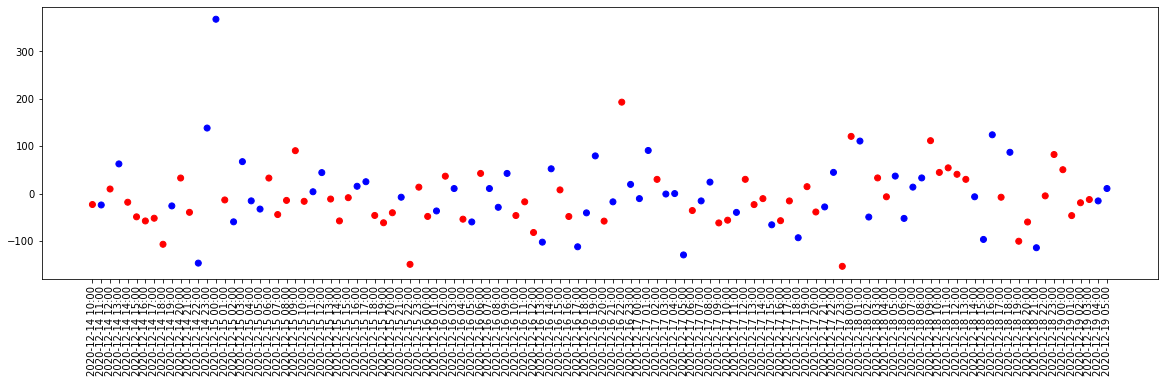

[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1]
money: EUR_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[58, 59]

test data
['2020-12-14 10:00'] to ['2020-12-19 06:00']

models\EUR_JPY_AdaBoost_1000.sav
accuracy_score: 0.4482758620689655
precision_score: [0.42857143 0.45945946]
[[18 40]
 [24 34]]
[-1.  1.  1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1. -1. -1.  1.
  1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.
  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
  1. -1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1.
  1. -1.  1.  1.  1. -1. -1.  1. -1. 

[[32 26]
 [33 25]]
[-1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1.
 -1. -1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.  1.
 -1. -1.  1. -1. -1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1.
 -1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.
  1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1.
 -1. -1.  1. -1. -1.  1.  1. -1.]
models\EUR_JPY_RBF SVM_1000.sav
accuracy_score: 0.47413793103448276
precision_score: [0.46938776 0.47761194]
[[23 35]
 [26 32]]
[-1.  1.  1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.
  1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1.  1.
  1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.
  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.
  1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1. -1.
  1.  1. -1.  1.

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-2-66f8bee6693e>:416: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(values_sum==[]):


0.9137931034482759
                        Rate
Datetime                    
2020-12-19 06:00  105.128367


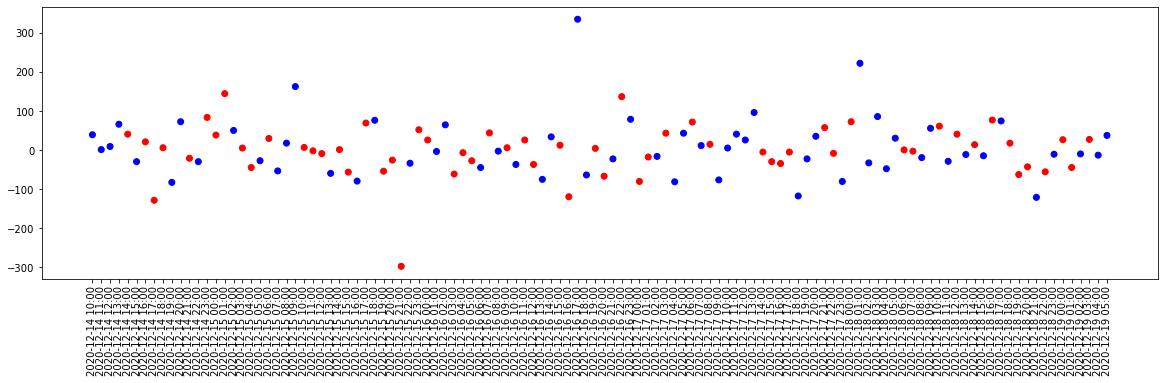

[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
money: AUD_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[55, 62]

test data
['2020-12-14 10:00'] to ['2020-12-19 06:00']

models\AUD_JPY_AdaBoost_1000.sav
accuracy_score: 0.5517241379310345
precision_score: [0.52542373 0.57894737]
[[31 24]
 [28 33]]
[-1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1. -1. -1.
 -1.  1. -1. -1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1.  1. -1.
 -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1.
  1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
  1. -1. -1.  1.  1.  1.  1.  1.  1. 

[[31 24]
 [28 33]]
[-1.  1.  1.  1. -1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.
 -1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1. -1.
  1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1.  1.
  1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.
  1.  1.  1. -1.  1. -1.  1. -1.]
models\AUD_JPY_RBF SVM_500.sav
accuracy_score: 0.5172413793103449
precision_score: [0.48648649 0.53164557]
[[18 37]
 [19 42]]
[-1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.
  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1. -1. -1.
  1.  1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.
  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1.
  1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.
  1. -1.  1.  1.  

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-2-66f8bee6693e>:416: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(values_sum==[]):


-0.8706896551724131
                       Rate
Datetime                   
2020-12-19 06:00  31.758937


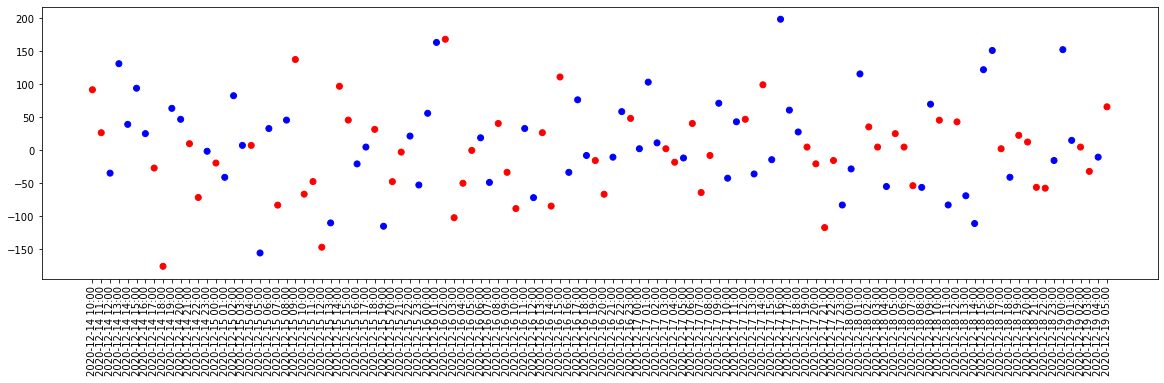

[0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]
money: GBP_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[53, 64]

test data
['2020-12-14 10:00'] to ['2020-12-19 06:00']

models\GBP_JPY_AdaBoost_1000.sav
accuracy_score: 0.5258620689655172
precision_score: [0.48148148 0.56451613]
[[26 27]
 [28 35]]
[-1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.
  1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1.
  1.  1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.
 -1. -1.  1. -1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1. -1.  1. -1.
  1.  1. -1.  1.  1.  1. -1.  1. -1. 

accuracy_score: 0.45689655172413796
precision_score: [0.39583333 0.5       ]
[[19 34]
 [29 34]]
[ 1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
 -1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.
  1.  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
 -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1.
  1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1. -1.  1.
  1. -1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1.
 -1.  1.  1.  1. -1.  1. -1.  1.]
models\GBP_JPY_RBF SVM_500.sav
accuracy_score: 0.5517241379310345
precision_score: [0.51515152 0.56626506]
[[17 36]
 [16 47]]
[ 1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
 -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.
  1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1.
  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.
  1.  1. -1.  

<ipython-input-2-66f8bee6693e>:416: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(values_sum==[]):


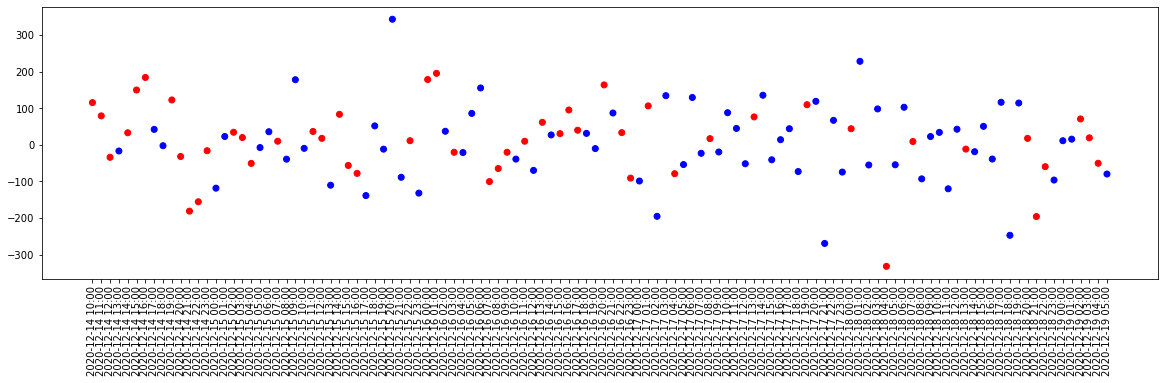

[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
money: NZD_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[56, 61]

test data
['2020-12-14 10:00'] to ['2020-12-19 06:00']

models\NZD_JPY_AdaBoost_1000.sav
accuracy_score: 0.5258620689655172
precision_score: [0.50666667 0.56097561]
[[38 18]
 [37 23]]
[-1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.
 -1.  1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1.
 -1. -1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.
 -1.  1.  1.  1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.
  1. -1.  1. -1. -1.  1. -1. -1.  1. 

 -1.  1. -1. -1.  1. -1.  1. -1.]
LOW
[-14.   8.   0.   2. -14.  -6.  -6.   0.  -2.   2.  -4.  -2.  16.  -2.
  14.  18.   0.  -4. -14.  16.  -6.  12. -12. -14.  -2.  -4.  -2.   4.
  -4.  -8.  14.  18.   8. -10.   4.  10.   6.  -2.  -2.   6. -16.  -4.
   4.  18.  -6.   8.  -4.  -4.   8.  -2.  -8.  14.   4.   0.   8.   2.
  16.   8.  12.   8.  -2.   6.  12. -10.   0.  -2.  -2. -14.  -4.  14.
   0.   6.   2.   8.  -4.  -2. -14.  16.  -2. -16.   8.  -2. -14.  10.
  18.   8.  14. -12.   4.  -8.   4.  -2.   4.  -2.  -4.   8.  -2.   8.
   4.  -2.   0.  -6.   8.  -4.  18.   0.  -2.  18.  -4.   6. -12.   4.
  -8.   0.   0. -14.]

ensemble_result: 0.5948275862068966
[-1  1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1 -1 -1  1 -1  1 -1 -1
 -1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1
  1 -1 -1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1 -1 -1 -1 -1  1  1  1
  1  1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1  1  1 -1  1 -1  1 -1  1 -1 -1  1
 -1  1  1 -1  1 -1  1 -1  1  1 -1  1 -1  1 

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-2-66f8bee6693e>:416: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(values_sum==[]):


-6.568965517241379
                       Rate
Datetime                   
2020-12-19 06:00  42.055568


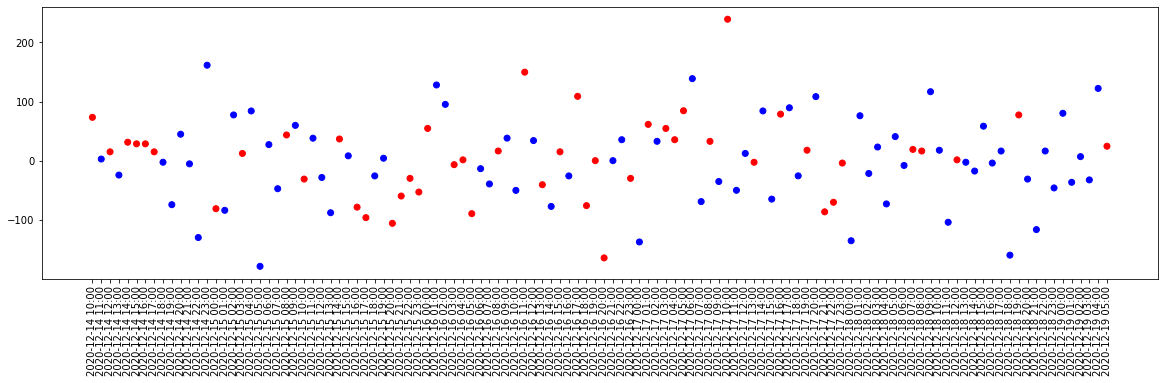

[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
money: CAD_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[68, 49]

test data
['2020-12-14 10:00'] to ['2020-12-19 06:00']

models\CAD_JPY_AdaBoost_1000.sav
accuracy_score: 0.4827586206896552
precision_score: [0.57142857 0.4       ]
[[32 36]
 [24 24]]
[ 1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1.
  1. -1. -1.  1. -1. -1. -1.  1.  1. -1.  1.  1.  1.  1.  1. -1. -1.  1.
 -1.  1.  1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.  1.
  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1. -1.
  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.
  1. -1.  1.  1. -1.  1. -1.  1.  1. 

accuracy_score: 0.4396551724137931
precision_score: [0.53191489 0.37681159]
[[25 43]
 [22 26]]
[-1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
 -1.  1. -1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
  1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1.
 -1.  1. -1.  1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.  1.
 -1. -1.  1.  1.  1. -1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.
  1.  1.  1. -1. -1. -1. -1.  1.]
models\CAD_JPY_RBF SVM_500.sav
accuracy_score: 0.4224137931034483
precision_score: [0.51612903 0.38823529]
[[16 52]
 [15 33]]
[-1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.
  1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.
 -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1.  1

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-2-66f8bee6693e>:416: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(values_sum==[]):


1.1465517241379313
                      Rate
Datetime                  
2020-12-19 06:00 -6.186052


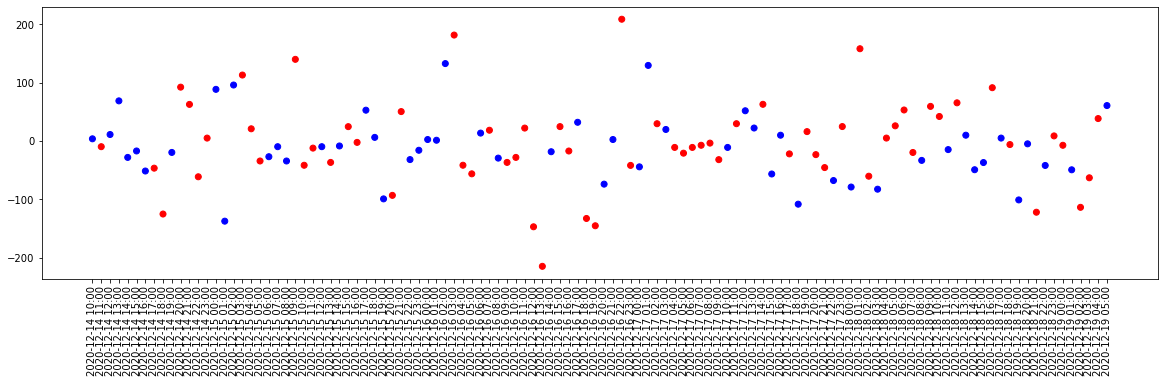

[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
money: CHF_JPY
NOW Data from120hours ago
 LOW/MID/HIGH
[59, 58]

test data
['2020-12-14 10:00'] to ['2020-12-19 06:00']

models\CHF_JPY_AdaBoost_1000.sav
accuracy_score: 0.5689655172413793
precision_score: [0.58333333 0.55882353]
[[28 30]
 [20 38]]
[-1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1.  1.  1. -1.
 -1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.
 -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1. -1.  1.  1.
  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1. -1.  1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1. -1. -1.  1. 

[[23 35]
 [27 31]]
[ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.
  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.
  1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.
  1.  1. -1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1.  1. -1.  1. -1. -1.
 -1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1.  1.  1.  1. -1.  1.  1.  1.
  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.
  1. -1. -1.  1. -1.  1.  1.  1.]
HIGH
[  6.   0.   0.  18.   0.   0.   2.  -4.   6. -10.   8.   4.   2.  12.
  18.  10.  16.  -2.  -2.   6.  -2.   8.  -2.  10.  18.  18.  -2.   0.
  14.  -2.   6.   2.   6.   4.   0. -12.   2.  16.   2.  16.  14.  -2.
  18.  -6.   6.  18.  18.   2. -14.   0.  14.  -6.   6.  12.   2.  -4.
 -14.  16.   4.   6.  10.   0.  10.  -6.  -2.  18. -10.  16.   6.  18.
   4.  -6.  -2.  -2.  10.   2.  18.  10.   0.  18.  12.  -4.   0.   8.
   2.   6.   8.  10.   0.  10.  18.   4.   4.  12.  14.   4.   8.  -2.
  16.  

C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stana\.conda\envs\predict_rate\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-2-66f8bee6693e>:416: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(values_sum==[]):


7.051724137931034
                        Rate
Datetime                    
2020-12-19 06:00  103.537385


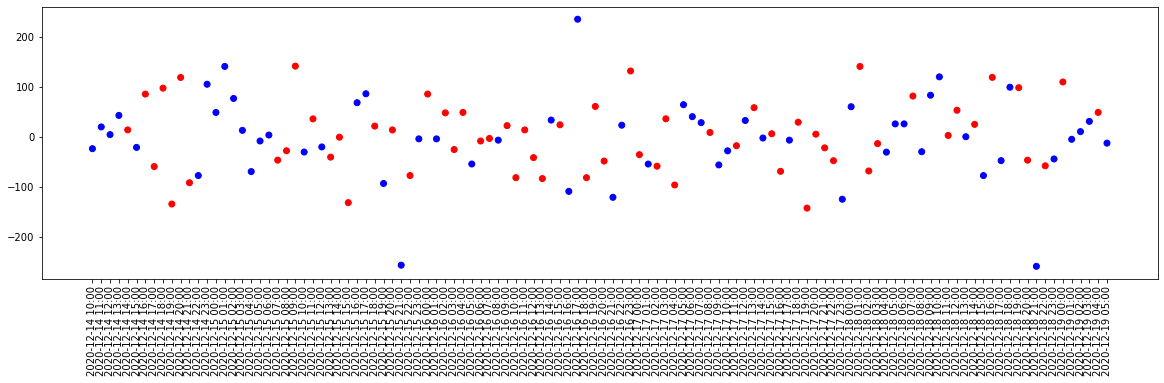

[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]
['USD_JPY: HIGH', 'EUR_JPY: HIGH', 'AUD_JPY: LOW', 'GBP_JPY: LOW', 'NZD_JPY: LOW', 'CAD_JPY: HIGH', 'CHF_JPY: HIGH']

profit_sum: -29.19999999999999
Ready... :2020-12-19 10:58:39.436382
Did you restart the kernel?
pay 1000: -29199.99999999999

In [2]:
# -*- coding: utf-8 -*-
from oandapyV20 import API
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments

import json
import datetime
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta

import time

get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import pickle
import math
import glob
import talib as ta
import shutil
import os

import schedule

#自分のアカウント、トークンをセット
accountID = "101-009-16415310-001"
access_token = '860c2d2dbbcd01b6d95939b6af6b5981-8664724ce0870220c55161d704137df6'

api = API(access_token=access_token, environment="practice")
        
# Oandaからcandleデータを取得する。
def getCandleDataFromOanda(instrument, api, date_from, date_to, granularity):
    params = {
        "from": date_from.isoformat(),
        "to": date_to.isoformat(),
        "granularity": granularity,
    }
    r = instruments.InstrumentsCandles(instrument=instrument, params=params)
    return api.request(r)

def oandaJsonToPythonList(JSONRes):
    
    data = []
    for res in JSONRes['candles']:
        temp = [((datetime.datetime.fromisoformat(res['time'][:19]))+datetime.timedelta(hours=+9)).strftime('%Y-%m-%d %H:%M')]#indexとなる時間を追加
        temp.extend([res['volume'],
            res['mid']['o'],
            res['mid']['h'],
            res['mid']['l'],
            res['mid']['c'],
            ])
        data.append(temp)
    return data

def logarism(x):
    return math.log(x)


def get_now_data(time, period_hours, money, foot, back_days = 0):
    
    all_data = []
    #time = time.replace(hour=7, minute=0, second=0, microsecond=0)
    #入力された日の当日の7時
    
    global PAST
    past = datetime.timedelta(hours=-PAST)
    
    NY = datetime.timedelta(hours=-14)
    back = datetime.timedelta(days=-back_days)
        
    date_to = time + NY + datetime.timedelta(seconds=-1) + back + past

    date_from = date_to + datetime.timedelta(hours=-period_hours)
    
    ret = getCandleDataFromOanda(money, api, date_from, date_to, foot)
    month_data = oandaJsonToPythonList(ret)#取得したデータを格納

    all_data.extend(month_data)#データを追加

    # pandas DataFrameへ変換
    df = pd.DataFrame(all_data)

    df.columns = ['Datetime','Volume', 'Open', 'High', 'Low', 'Close']
    df['Open'] = df['Open'].astype('double')
    df['Close'] = df['Close'].astype('double')
    
    
    close = np.array(df["Close"]).astype(float)
    #以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる
#     #単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
#     df["SMA5"]= ta.SMA(close, timeperiod=5) / close * 100
#     df["SMA10"]= ta.SMA(close, timeperiod=10) / close * 100
#     #df["RSI"] = ta.RSI(close, timeperiod=9) / close * 1000
#     #ボリンジャーバンド 
#     upper, middle, lower = ta.BBANDS(close, timeperiod=10, nbdevup=2, nbdevdn=2)
#     df["BBANDS+σ"] = upper / close * 100
#     df["BBANDS-σ"] = lower / close * 100
    
#     df['Rate']=(df['Close']-df['Open'])/df['Open']
    
#     df['Open'] = df['Open'].apply(lambda x: logarism(x))
#     df['Close'] = df['Close'].apply(lambda x: logarism(x))
    
    df['Rate']=(df['Close'].astype('double')-df['Open'].astype('double'))/df['Open'].astype('double')
    df['Rate']=df['Rate']*100
    
    df['Rate']=df['Rate']*1000
    
    df = df.dropna()
    
    df = df.drop('Open', axis=1)
    df = df.drop('High', axis=1)
    df = df.drop('Low', axis=1)
    df = df.drop('Close', axis=1)
    df = df.drop('Volume', axis=1)
    
    df = df.set_index('Datetime')
    #print(df)
    
    
    return df
    
def get_csv(back_days, hours, money):
    
    time = datetime.datetime.now() 
    
    df = get_now_data(time, period_hours=hours, money=money, foot = FOOT , back_days=back_days)
    date_to = (time+datetime.timedelta(days=-back_days)+datetime.timedelta(seconds=-1)).strftime("%Y-%m-%d")
    date_from = (time + datetime.timedelta(hours=-hours)+datetime.timedelta(days=-back_days)).strftime("%Y-%m-%d")
    df.to_csv("csv/"+str(money)+"_"+ date_from + "_" + date_to +"_"+str(hours)+'.csv', mode = 'w')
    print('"'+str(money)+"_"+ date_from + "_" + date_to +"_"+str(hours)+'.csv', end='", ')
    
    return df

def get_moneys_csv(back_days, hours, moneylist):
    csvlist = []
    
    time = datetime.datetime.now()
    date_to = (time+datetime.timedelta(days=-back_days)+datetime.timedelta(seconds=-1)).strftime("%Y-%m-%d")
    date_from = (time + datetime.timedelta(hours=-hours)+datetime.timedelta(days=-back_days)).strftime("%Y-%m-%d")
    
    for i in range (len(moneylist)):
        get_csv(back_days, hours, money=moneylist[i])
        csvlist.extend([str(moneylist[i])+"_"+ date_from + "_" + date_to +"_"+str(hours)+'.csv'])
    
    return csvlist
        
def classify_two(x, c):
        if x<=0:
            c[0]+=1
            return -1
        elif 0<x:
            c[1]+=1
            return 1
        

def predict(dataname, moneyname, test_hours, back_day, datanum):

    df = pd.read_csv("csv/"+dataname, index_col='Datetime')
    
    count = [0,0]
    #df['class'] = (df["Rate"]).apply(lambda x: classify(x, count, 0.001))
    df['class'] = (df["Rate"]).apply(lambda x: classify_two(x, count))
    df['class'] = df['class'].shift(-1)
    print("Train Data")
    print(" LOW/HIGH")
    print(count)
    
    X = df.drop('class', axis=1)
    
    
    y = df['class']
    X = X.drop(X.index[len(X)-1])
    y = y.dropna()
    

    df_now = get_now_data(datetime.datetime.now(), period_hours=test_hours, money=moneyname, foot = FOOT, back_days = back_day)
    print("money: "+moneyname)
    
    count = [0,0]
    #df['class'] = (df["Rate"]).apply(lambda x: classify(x, count, 0.001))
    df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
    df_now['class'] = df_now['class'].shift(-1)
    print("NOW Data from" +str(test_hours)+ "hours ago")
    print(" LOW/MID/HIGH")
    print(count)
    
    print("learning data")
    print(df.head(1).index.values, end=' to ')
    print(df.tail(1).index.values)
    
    print("")
    print("test data")
    print(df_now.head(1).index.values,end=' to ')
    print(df_now.tail(1).index.values)
    print("")
    X_now = df_now.drop('class', axis=1)
    
    X_next = X_now.tail(1) #最終予測に利用
    y_now = df_now['class']
    X_now = X_now.drop(X_now.index[len(X_now)-1])
    y_now = y_now.dropna()
    
    X_train = X
    y_train = y
    X_test = X_now
    y_test = y_now
    
    
    names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
             "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant Analysis",
             "Quadratic Discriminant Analysis"]
    classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
    
    accuracy_scores = []
    precision_scores = []
    next_class = []
    profit = []
    
    clearlist = []
    
    for name, clf in zip(names, classifiers):
        print(name)
        clf.fit(X_train, y_train)
        result = clf.predict(X_test)
        profit, values = calc_profit(result, y_test)
        precision = precision_score(y_test, result, average=None)
        accuracy = accuracy_score(y_test, result)
        confusion = confusion_matrix(y_test, result)
        
        if(1):
        #if(precision[0]>0.45 and precision[1]>0.45 and precision[0]!=1 and precision[1]!=1 and accuracy>0.55 and abs(confusion[0][0]-confusion[1][1])<(confusion[0][0]+confusion[1][1])/4):
        #if(precision[0]>0.4 and precision[1]>0.4):
#             score = clf.score(X_test, y_test)
            next_class.extend(clf.predict(X_next))

            print('accuracy_score: ', end='')
            print(accuracy_score(y_test, result))
            accuracy_scores.extend([accuracy_score(y_test, result)])
            print('confusion_matrix: ')
            print(confusion_matrix(y_test, result))
            print('precision_score: ', end='')
            print(precision_score(y_test, result, average=None))
            precision_scores.extend([precision_score(y_test, result, average=None)])

            print(str(len(result))+"hours trade")
            print("profit: "+str(profit))

            print('', flush=True)

            model_name = moneyname + "_" + name + "_" + str(datanum) +".sav"
            #clearlist.extend([model_name])
            print("CLEAR: " + model_name)
            pickle.dump(clf, open("models/"+model_name, 'wb'))

    #print(clearlist)
    return accuracy_scores, precision_scores, next_class, profit

def make_models(test_hours, namelist, moneylist, back_days, datanum):
    for i in range(len(namelist)):
        print(namelist[i], flush=True)
        acc, pre, next_class, profit = predict(namelist[i], moneylist[i], test_hours, back_days, datanum)
        print(acc)


def calc_profit(predict_result, true_data):
    win=0
    lose=0
    for i in range(len(predict_result)):
            if (predict_result[i]==-1):#Low予想のとき
                if (predict_result[i]==true_data[i]): #予測成功
                    win+=1
                else:
                    lose+=1
            elif(predict_result[i]==1):#High予想の時
                if (predict_result[i]==true_data[i]): #予測成功
                    win+=1
                else:
                    lose+=1
    profit = win*0.9-lose #利率を算出
    values = predict_result*profit #予測結果×利率により予測の価値を算出
    return profit, values

def plot_result(index, predict_result, true_data):
    plt.figure(figsize=(20,5))
    index = index.astype(float)

    color = []
    marker = []
    accuracy = []
    
    for x in range(0,len(predict_result)):
        if true_data.values[x] == predict_result[x]:
            color.extend(['blue'])
            accuracy.extend([1])

        else:
            color.extend(['red'])
            accuracy.extend([0])


    plt.scatter(index.index.values, index["Rate"].values, color=color)

    plt.xticks(rotation=90)
    plt.show()
    
    return accuracy


def ensemble(model_names, moneyname, hours):
    

    global PAGE
    
    temp = PAGE
    #PAGE = trader.select_money(moneyname, temp)
    
    df_now = get_now_data(datetime.datetime.now(), period_hours=hours, money=moneyname, foot = FOOT, back_days = NIGHT)###########
    print("money: "+moneyname)
    count = [0,0]
    
    df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
    df_now['class'] = df_now['class'].shift(-1)
    print("NOW Data from" +str(hours)+ "hours ago")
    print(" LOW/MID/HIGH")
    print(count)

    print("")
    print("test data")
    print(df_now.head(1).index.values,end=' to ')
    print(df_now.tail(1).index.values)
    print("")
    X_now = df_now.drop('class', axis=1)
    
    X_next = X_now.tail(1) #最終予測に利用
    y_now = df_now['class']
    X_now = X_now.drop(X_now.index[len(X_now)-1])
    y_now = y_now.dropna()
    
    values = []
    values_sum = []
    win=0
    lose=0
    answer = 0
    
    for x in range(len(model_names)):
        clf = pickle.load(open(model_names[x], 'rb')) #clfをload
        print(model_names[x])
        result = clf.predict(X_now) #predict
        precision = precision_score(y_now, result, average=None)
        #if(precision[0]!=0 and precision[1]!=0 and precision[0]!=1 and precision[1]!=1):
        if(1):
       
            #score表示
            print("accuracy_score: ", end="")
            print(accuracy_score(y_now, result))
            print("precision_score: ", end="")
            print(precision)
            print(confusion_matrix(y_now, result))

            profit, values = calc_profit(result, y_now) #予測結果について利率と、予測*利率による予測の信頼性を算出
            values = result
            
            
            #answer += clf.predict(X_next)[0]*profit
            answer += clf.predict(X_next)[0]*accuracy_score(y_now, result)
            #values = result*accuracy_score(y_now, result)
            if len(values_sum)==0:#1回目は配列をコピー
                values_sum = values
            else:
                values_sum += values #２回目からは加算
            print(values)
    
        #plot_result(X_now, result, y_now)
    if(answer>0):
        print("HIGH")
        hl = "HIGH"
        #trader.high_entry()
        
    else:
        print("LOW")
        hl = "LOW"
        #trader.low_entry()    
    print(values_sum)
    
    if(values_sum==[]):
        print("No model")
        return 0
    
    ensemble_result = np.where(values_sum<0, -1, 1) #クラス分類
    
    print("")
    print("ensemble_result: ",end='')
    print(accuracy_score(y_now.values, ensemble_result))
    print(ensemble_result)
    print(y_now.values)
    print(values_sum)
    print("precision_score: ", end="")
    print(precision_score(y_now, ensemble_result, average=None))
    print('confusion_matrix: ')
    print(confusion_matrix(y_now, ensemble_result))
    print("profit: ",end='')
    profit, values = calc_profit(ensemble_result, y_now)
    print(profit)
    print("next: ",end='', flush=True)
    print(answer)
    
    print(X_next.head(1))
    accuracy = plot_result(X_now, ensemble_result, y_now)
    
    global profit_sum
    profit_sum += profit
    
    global RESULT
    RESULT.extend([moneyname+": "+hl])
    return accuracy
        
    
def compere_ensemble(models_array, moneys_array, days):
    results = []
    
    for i in range(len(moneys_array)):
        results.append(np.array(ensemble(models_array[i], moneys_array[i], days)).astype('int'))
    
    np.savetxt('out.csv',results,delimiter=',')
    print(results)
    
def ensemble_set(models_array, moneys_array, hours):
    
    for i in range(len(models_array)):
        print(ensemble(models_array[i], moneys_array[i], hours))    

def plot_rates(hours, moneys):
    
    result = []
    accord = []
    plt.figure(figsize=(40,20))
    for i in range(len(moneys)):
#         df_now = get_now_data(datetime.datetime.now(), period_Days=days, money=moneys[i], foot = 'D', back_days = 0)
        df_now = get_now_data(datetime.datetime.now(), period_hours=hours, money=moneys[i], foot = FOOT, back_days = 0)
        plt.plot(df_now.index.values, df_now["Rate"].values)
        count = [0,0]
        df_now['class'] = (df_now["Rate"]).apply(lambda x: classify_two(x, count))
        result.append(df_now["class"].values)
    
    win = 0
    lose = 0
    
    for l in range(len(result[0])):
        temp = 0
        for m in range(len(moneys)):
            if result[m][l]==1:
                temp+=1
        if(temp==len(moneys)/2):
            accord.extend([-1])
            lose += len(moneys)/2
            win += len(moneys)/2
        else:
            accord.extend([temp])
            win += max(temp, len(moneys)-temp)
            lose += min(temp, len(moneys)-temp)
    
    
    plt.xticks(rotation=90)
    plt.hlines([0], 0, days, "blue", linestyles='dashed')     # hlines
    plt.show()
    print(accord)
    
    pay = 1000
    pay_sum = pay*len(moneys)
    
    print("win: ", win)
    print("lose: ", lose)
    print("rate: ", win/(win+lose))
    print("profit: ", (win*0.9-lose)*pay_sum)

COUNT = 0
PAGE = 0
    
def job():
    global COUNT
    
    time.sleep(5)
    print("START")
    
    if COUNT == 0:
        print("Set up browser...")
        trader.setup_demo()
        time.sleep(3)
    else:
        print("Ready for entry...")
        time.sleep(13)
    main()
    COUNT += 1
    
    #print(RESULT)
    print('')
    print("profit_sum: ", end='')
    print(profit_sum)
    RESULT = []
#     print("Rebuild models...")
#     get_csv_and_make_models()
    print('')
    print('finished: ', end='')
    print(datetime.datetime.now())
    print('waiting...', flush=True)

    
def main():
    
    models = [glob.glob('models/USD_JPY*.sav'), glob.glob('models/EUR_JPY*.sav'), glob.glob('models/AUD_JPY*.sav'),
              glob.glob('models/GBP_JPY*.sav'), glob.glob('models/NZD_JPY*.sav'), glob.glob('models/CAD_JPY*.sav'),
              glob.glob('models/CHF_JPY*.sav')]#, glob.glob('ZAR_JPY*.sav')]
    moneys = ['USD_JPY', 'EUR_JPY', 'AUD_JPY', 'GBP_JPY', 'NZD_JPY', 'CAD_JPY', 'CHF_JPY']#, 'ZAR_JPY']
    
    #ensemble(CHF_models, "CHF_JPY", 60)   #選択した通貨に対してアンサンブル
    #compere_ensemble(models, moneys, 30)   #それぞれの通貨に対してアンサンブルした結果をcsvに返す
    #plot_rates(30,moneys)
    ensemble_set(models, moneys, DAYS*24)  #指定したmoneyで結果を出す
    print(RESULT)

    print('')
    print("profit_sum: ", end='')
    print(profit_sum)
    
def get_csv_and_make_models():
    
    shutil.rmtree('csv')
    shutil.rmtree('models')
    
    os.mkdir('csv')
    os.mkdir('models')
    
    moneylist=['AUD_JPY', 'CAD_JPY', 'CHF_JPY']
    moneylist = ['USD_JPY', 'EUR_JPY', 'AUD_JPY', 'GBP_JPY', 'NZD_JPY', 'CAD_JPY', 'CHF_JPY']#, 'ZAR_JPY']
    #array100 = get_moneys_csv(back_days=5, days=100, moneylist = moneylist)
    array500 = get_moneys_csv(back_days=DAYS*2, hours=500, moneylist = moneylist) # 指定期間のcsvをsave
    array1000 = get_moneys_csv(back_days=DAYS*2, hours=1000, moneylist = moneylist)
#     array1500 = get_moneys_csv(back_days=DAYS*2, hours=1500, moneylist = moneylist)
#     array2000 = get_moneys_csv(back_days=DAYS*2, hours=2000, moneylist = moneylist)
#     array2500 = get_moneys_csv(back_days=DAYS*2, hours=2500, moneylist = moneylist)
#     array3000 = get_moneys_csv(back_days=DAYS*2, hours=3000, moneylist = moneylist)
    
   #make_models(test_days, namelist, moneylist, back_days, datanum):
    
    #make_models(24, array100, moneylist, 1, 100)
    make_models((DAYS)*24, array500, moneylist, DAYS, 500)
    make_models((DAYS)*24, array1000, moneylist, DAYS, 1000)
#     make_models((DAYS)*24, array1500, moneylist, DAYS, 1500)
#     make_models((DAYS)*24, array2000, moneylist, DAYS, 2000)
#     make_models((DAYS)*24, array2500, moneylist, DAYS, 2500)
#     make_models((DAYS)*24, array3000, moneylist, DAYS, 3000)

NIGHT = 0
FOOT = 'H1'

DAYS = 5

PAST = 0

get_csv_and_make_models()
RESULT = []

profit_sum = 0

# now = datetime.datetime.now()
# start_time = datetime.datetime(now.year, now.month, now.day, now.hour+1, 0, 0)
# print((start_time-now).total_seconds()-10)
# time.sleep((start_time-now).total_seconds()-10)


#import trader
#trader.setup_demo()
main()
#COUNT += 1
# print(RESULT)
# print('')
# print("profit_sum: ", end='')
# print(profit_sum)
# print("pay 1000: ", end=str(profit_sum*1000))

#schedule.every(60*59).seconds.do(job)

print('Ready... :', end='')
print(datetime.datetime.now())
print("Did you restart the kernel?")
schedule.every().day.at("23:00").do(job)
schedule.every().day.at("00:00").do(job)
schedule.every().day.at("01:00").do(job)
schedule.every().day.at("02:00").do(job)
schedule.every().day.at("03:00").do(job)
schedule.every().day.at("04:00").do(job)
schedule.every().day.at("07:00").do(job)
schedule.every().day.at("08:00").do(job)
schedule.every().day.at("09:00").do(job)
schedule.every().day.at("10:00").do(job)
schedule.every().day.at("11:00").do(job)
schedule.every().day.at("12:00").do(job)
schedule.every().day.at("13:00").do(job)
schedule.every().day.at("14:00").do(job)
schedule.every().day.at("15:00").do(job)
schedule.every().day.at("16:00").do(job)
schedule.every().day.at("17:00").do(job)
schedule.every().day.at("18:00").do(job)
schedule.every().day.at("19:00").do(job)
schedule.every().day.at("20:00").do(job)
schedule.every().day.at("21:00").do(job)
schedule.every().day.at("22:00").do(job)


# while True:
#     schedule.run_pending()
#     time.sleep(2)

# print(RESULT)

# print('')
# print("profit_sum: ", end='')
# print(profit_sum)

print("pay 1000: ", end=str(profit_sum*1000))









